In [1]:
import ray
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import norm
from itertools import product, combinations
from collections import Counter
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
class SimpleLanguageModel:
    def __init__(self, vocab, training_data, smoothing=1e-6):
        # vocab is a list of single chars
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.prob_matrix = np.zeros((self.vocab_size, self.vocab_size, self.vocab_size))
        self.smoothing = smoothing
        self._initialize_probabilities(training_data)

    def _initialize_probabilities(self, training_data):
        # we are going to create the transition probs given data -
        # essentially, this does MLE

        # we have trigram and bigram dicts i.e. tuple vocab -> count
        self.trigram_counts = defaultdict(int)
        self.bigram_counts = defaultdict(int)

        for sequence in training_data:
            # for every sequence in the data len(seq) >= 3:
            # 1. check the previous token
            # 2. check the one before that
            # 3. count trigrams and bigrams
            tokens = list(sequence)
            for i in range(2, len(tokens)):
                prev_token_1 = tokens[i - 2]
                prev_token_2 = tokens[i - 1]
                next_token = tokens[i]

                # ensure tokens in vocab
                if prev_token_1 in self.vocab and prev_token_2 in self.vocab and next_token in self.vocab:
                    # count the bigrams
                    self.bigram_counts[(prev_token_1, prev_token_2)] += 1
                    # count the trigrams
                    self.trigram_counts[(prev_token_1, prev_token_2, next_token)] += 1

        self._update_prob_matrix()

    def _update_prob_matrix(self):
        for i, j, k in product(range(self.vocab_size), repeat=3):
        # for each trigram:
            # 1. if there is a bigram
            #    a. get the vocab indices of each token
            #    b. at the trigram prob in the prob_matrix, set prob

            # prob of observing a given trigram is normalized by the number
            # of times the preceding bigram occurs i.e.:
            #    we saw "abc" 3 times, and saw "ab" 4 times.
            #    thus, the prob of seeing "c | ab" = 3/4 = 0.75

            prev_token_1 = self.vocab[i]
            prev_token_2 = self.vocab[j]
            next_token = self.vocab[k]
            trigram_count = self.trigram_counts[(prev_token_1, prev_token_2, next_token)]
            bigram_count = self.bigram_counts[(prev_token_1, prev_token_2)]
            
            ## when the bigram count is zero -> trigram count will also be zero
            ## thus the target sentence never showed up
            ## thus low probability
            if bigram_count == 0:
                self.prob_matrix[i, j, k] = self.smoothing                
            if trigram_count == 0:
                self.prob_matrix[i, j, k] = self.smoothing
            else:
                self.prob_matrix[i, j, k] = trigram_count/bigram_count
                                    
    def update_probabilities(self, new_data):
        # basically, just update the counts with new data without first initializing
        for sequence in new_data:
            tokens = list(sequence)
            for i in range(2, len(tokens)):
                prev_token_1 = tokens[i - 2]
                prev_token_2 = tokens[i - 1]
                next_token = tokens[i]

                if prev_token_1 in self.vocab and prev_token_2 in self.vocab and next_token in self.vocab:
                    self.bigram_counts[(prev_token_1, prev_token_2)] += 1
                    self.trigram_counts[(prev_token_1, prev_token_2, next_token)] += 1

        # then re-calc the prob matrix
        self._update_prob_matrix()

    def get_probability(self, prev_token_1, prev_token_2, next_token):
        # retrieve prob of trigram from prob_matrix
        idx_prev1 = self.vocab.index(prev_token_1)
        idx_prev2 = self.vocab.index(prev_token_2)
        idx_next = self.vocab.index(next_token)

        return self.prob_matrix[idx_prev1, idx_prev2, idx_next]

    def get_negative_log_likelihood(self, sequence):
        prob = self.get_sequence_probability(sequence)
        if prob == 0:
            return np.inf
        return -np.log(prob)

    def get_next_token_probabilities(self, prev_token_1, prev_token_2):
        # retrieve prob *vector* over possible next tokens given bigram
        idx_prev1 = self.vocab.index(prev_token_1)
        idx_prev2 = self.vocab.index(prev_token_2)

        probabilities = self.prob_matrix[idx_prev1, idx_prev2]
        return {self.vocab[i]: probabilities[i] for i in range(self.vocab_size)}

    def get_sequence_probability(self, sequence):
        # likelihood of observing an entire sequence
        # given the probs in the transition prob matrix

        # e.g. whats the prob of the next token given preceding tokens
        # NOTE: only works for sequences where len(seq) >= 3
        tokens = list(sequence)
        prob = 1.0
        for i in range(2, len(tokens)):
            prev_token_1 = tokens[i - 2]
            prev_token_2 = tokens[i - 1]
            next_token = tokens[i]
            prob *= self.get_probability(prev_token_1, prev_token_2, next_token)
        return prob
        
    def generate_sequence(self, start_tokens, length):
        # probabilistic inference given a prompt
        sequence = list(start_tokens)
        for _ in range(length - len(start_tokens)):
            prev_token_1 = sequence[-2]
            prev_token_2 = sequence[-1]
            next_token_probs = self.get_next_token_probabilities(prev_token_1, prev_token_2)
            tokens = list(next_token_probs.keys())
            probs = list(next_token_probs.values())
            next_token = np.random.choice(tokens, p=probs)
            sequence.append(next_token)
        return ''.join(sequence)

In [3]:
def likelihood_ratio_to_probability(likelihood_ratio, prior_in=0.5):
    # prior prob for being out is symmetric to in
    prior_out = 1 - prior_in

    # compute the marginal likelihood
    marginal_likelihood = (likelihood_ratio * prior_in) + (1 / likelihood_ratio * prior_out)

    # bayes to get the posterior probability of membership
    posterior_in = (likelihood_ratio * prior_in) / marginal_likelihood

    return posterior_in
    
def estimate_pr_y_in_s_under_model(model, s, y_star, num_samples=10000):
    # util function to estimate the prob of a char occurring in a
    # sequence given a model by just generating a bunch of sequences
    count_y_in_s = 0
    for _ in range(num_samples):
        generated_sequence = model.generate_sequence(s[:2], len(s))
        if y_star in generated_sequence:
            count_y_in_s += 1
    return count_y_in_s / num_samples

def compute_true_pr_y_in_s_under_model(model, start_tokens, length, y_star):
    # actual prob
    vocab = model.vocab
    vocab_size = model.vocab_size
    idx_to_token = {i: token for i, token in enumerate(vocab)}
    token_to_idx = {token: i for i, token in enumerate(vocab)}

    num_positions = length - len(start_tokens)
    all_sequences_indices = product(range(vocab_size), repeat=num_positions)
    start_indices = [token_to_idx[token] for token in start_tokens]

    total_prob = 0.0
    prob_y_in_s = 0.0

    for seq_indices in all_sequences_indices:
        sequence_indices = start_indices + list(seq_indices)
        sequence_tokens = [idx_to_token[idx] for idx in sequence_indices]

        prob = 1.0
        for t in range(2, length):
            idx_prev1 = sequence_indices[t - 2]
            idx_prev2 = sequence_indices[t - 1]
            idx_next = sequence_indices[t]
            prob *= model.prob_matrix[idx_prev1, idx_prev2, idx_next]

        total_prob += prob
        if y_star in sequence_tokens:
            prob_y_in_s += prob

    pr_y_in_s = prob_y_in_s / total_prob
    return pr_y_in_s

def generate_data_from_vocab(vocab, num_sequences=500, sequence_length=3, bias_factor=0):
    data = []
    for _ in range(num_sequences):
        sequence = []
        for i in range(sequence_length):
            if i > 0 and random.random() < bias_factor / (bias_factor + 1):
                # we are going to bias the sequences towards creating double chars
                # e.g. "aab" and "acc" are slightly more likely than "cab", etc.
                sequence.append(sequence[-1])
            else:
                sequence.append(random.choice(vocab))
        data.append(''.join(sequence))
    return data

In [8]:
@ray.remote
def auc_calculation(vocab_size, seq_length, cond_length):

    vocab = [i for i in string.ascii_lowercase[:vocab_size]]    
    num_sequences=vocab_size**(seq_length-1)    
    train=generate_data_from_vocab(vocab, num_sequences=num_sequences, sequence_length=seq_length)        
    test=generate_data_from_vocab(vocab, num_sequences=num_sequences, sequence_length=seq_length)    
    test=np.concatenate([[t[:-1]+v for v in vocab] for t in test]).tolist()
    labels = [1*(s in train) for s in test]
    label_ratio=np.mean(labels)
    target_model = SimpleLanguageModel(vocab, train)
        
    scores=[]
    our_scores=[]
    for sequence in tqdm(test):
        
        ## sampling s
        y_star,s=sequence[-1],sequence[:-1]
        condition=random.choice(list(combinations(s, r=cond_length)))
        condition=''.join(condition)+y_star
        
        ## calculate probabilities
        data_without_sequence = generate_data_from_vocab(vocab, num_sequences=num_sequences, sequence_length=seq_length)
        data_without_sequence = [item for item in data_without_sequence if item!=sequence]
        data_world=data_without_sequence+train
        shadow_model = SimpleLanguageModel(vocab, data_without_sequence)
        world_model = SimpleLanguageModel(vocab, data_world)
        
        p_in = target_model.get_sequence_probability(condition)                
        p_out = shadow_model.get_sequence_probability(condition) 
        p_world = world_model.get_sequence_probability(condition)
        p_s_in_D = likelihood_ratio_to_probability(p_in/p_out)                
        scores.append(p_in/p_out)
        our_scores.append((p_world-p_out*(1-p_s_in_D))/p_s_in_D)
    
    ## save naive score
    fpr,tpr, _ = roc_curve(labels, scores)
    fpr_our,tpr_our, _ = roc_curve(labels, our_scores)
    roc_auc = auc(fpr,tpr)    
    roc_auc_our = auc(fpr_our,tpr_our)
    
    return label_ratio, roc_auc, roc_auc_our

In [9]:
ray.init()

2024-10-28 10:14:07,185	INFO worker.py:1816 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.38.0


In [10]:
vocab_sizes=[4,5,6]
seq_lengths=[4,5]
parameters=[]
for vs in vocab_sizes:
    for sl in seq_lengths:
        for cl in range(2,sl):
            parameters.append({'vocab_size':vs, 'seq_length':sl, 'cond_length':cl})            
print(len(parameters))

15


In [12]:
parallel = [auc_calculation.remote(**para) for para in parameters]
results = ray.get(parallel)

100%|██████████| 3125/3125 [00:39<00:00, 78.53it/s]


 96%|█████████▌| 7481/7776 [01:55<00:03, 83.97it/s]


100%|██████████| 7776/7776 [02:00<00:00, 64.68it/s]


In [17]:
vis_data = []
for i in range(len(parameters)):
    vis_data.append(list(parameters[i].values()) + [results[i][1], 'Naive'])
    vis_data.append(list(parameters[i].values()) + [results[i][-1], 'Ours'])
vis_data = pd.DataFrame(
    vis_data,
    columns=['vocab_size','seq_length','cond_length','auc','method']
)
vis_data = vis_data.astype(
    dtype= {
        "vocab_size":"int64",
        "seq_length":"int64",
        "cond_length":"int64",
        "auc":"float64",
    }
)    

/Users/binhan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


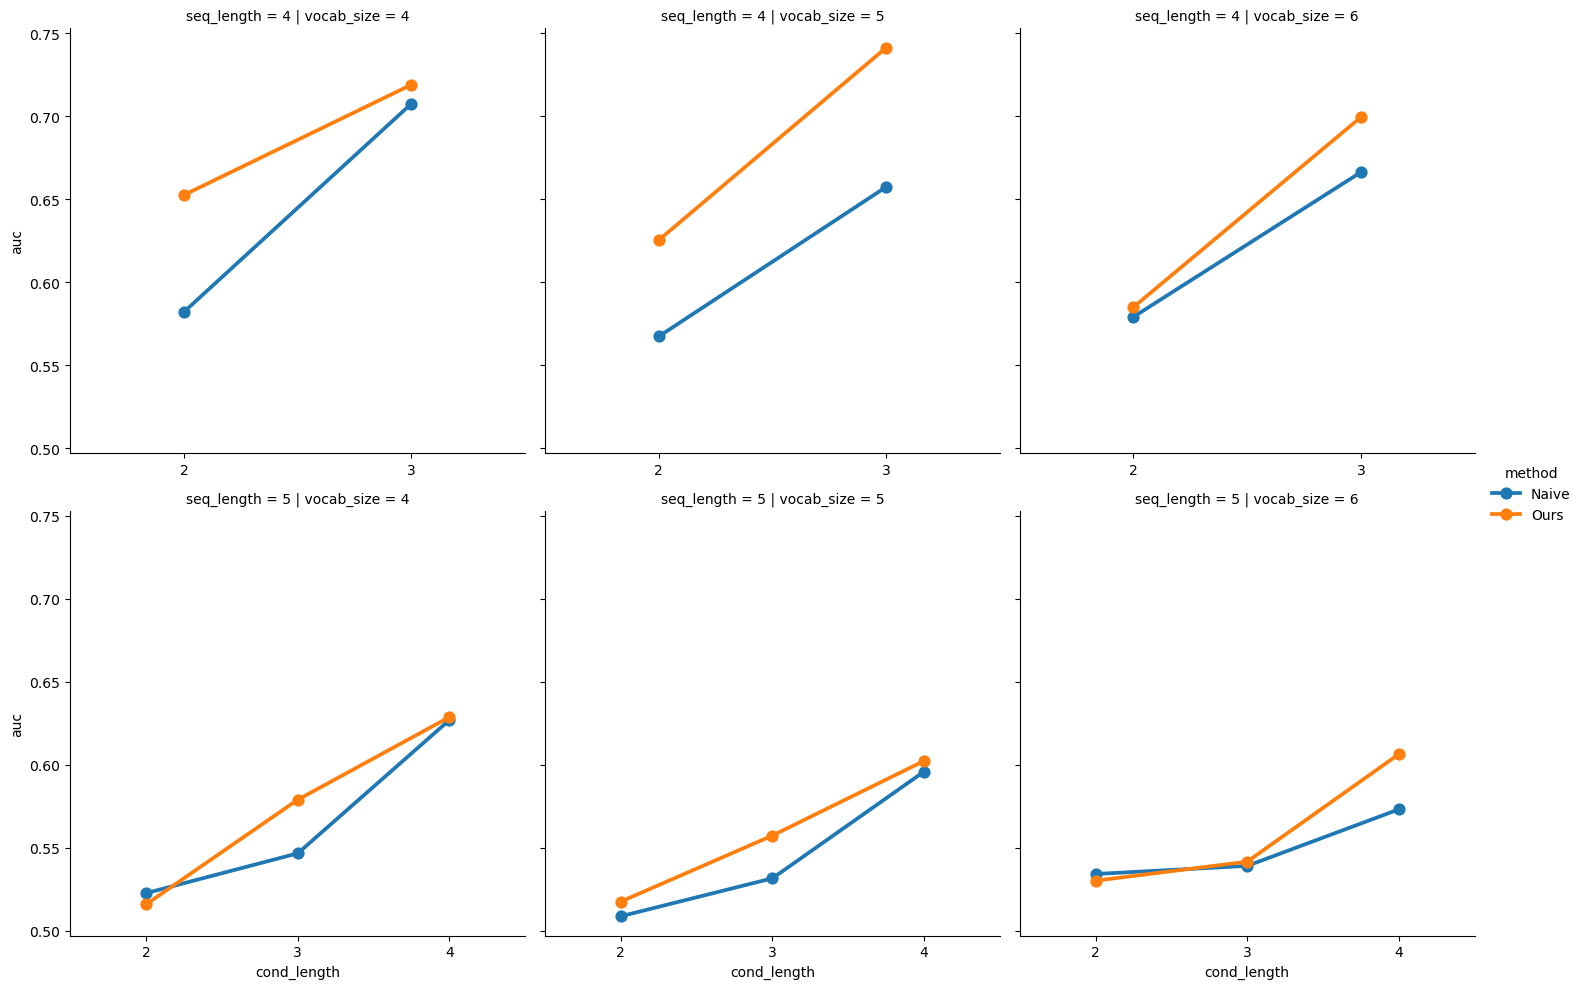

In [18]:
sns.catplot(
    vis_data, kind="point",
    x="cond_length", y="auc",hue="method",
    col="vocab_size",    
    row="seq_length",
    sharex=False
)
pass

/Users/binhan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


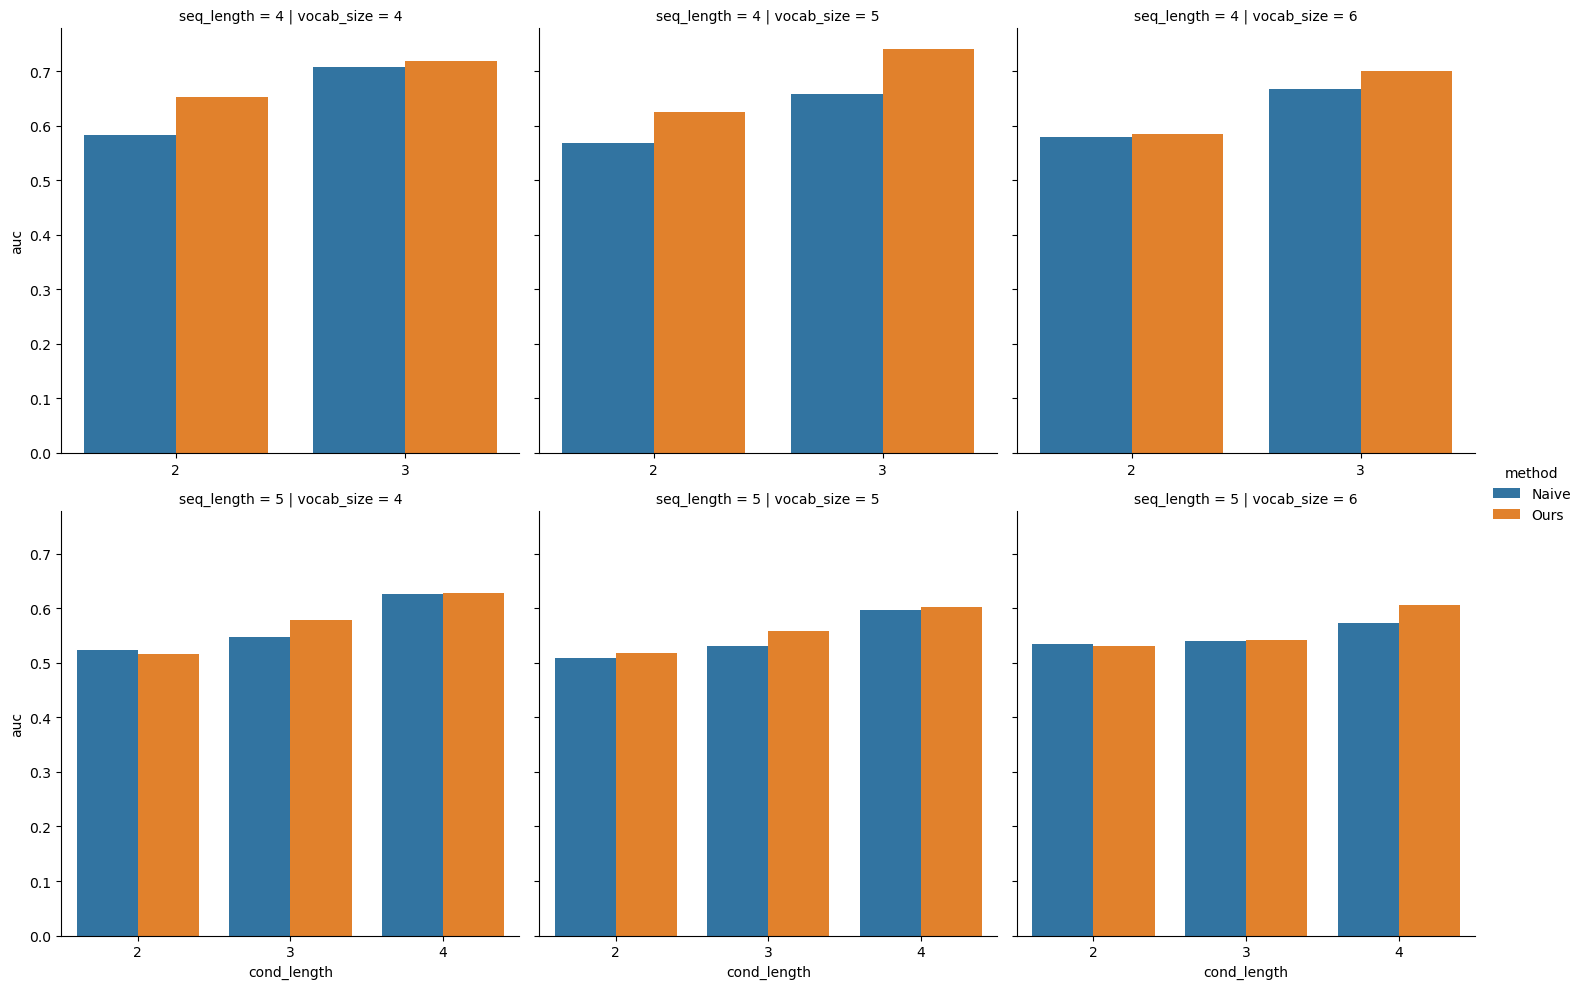

In [19]:
sns.catplot(
    vis_data, kind="bar",
    x="cond_length", y="auc",hue="method",
    col="vocab_size",
    row="seq_length",
    sharex=False
)
pass